# NHANES I Survival Model

This is a cox proportional hazards model on data from <a href="https://wwwn.cdc.gov/nchs/nhanes/nhanes1">NHANES I</a> with followup mortality data from the <a href="https://wwwn.cdc.gov/nchs/nhanes/nhefs">NHANES I Epidemiologic Followup Study</a>. It is designed to illustrate how SHAP values enable the interpretion of XGBoost models with a clarity traditionally only provided by linear models. We see interesting and non-linear patterns in the data, which suggest the potential of this approach. Keep in mind the data has not yet been checked by us for calibrations to current lab tests and so you should not consider the results as actionable medical insights, but rather a proof of concept. \
<a href="https://github.com/dmlc/xgboost/tree/master/demo/guide-python">Python API reference of xgboost</a> <br>
<a href="https://github.com/dmlc/xgboost/tree/master/demo/guide-python">XGBoost Demo GitHub repo Code</a> in <a href="https://github.com/dmlc">dmlc</a> <br>
<a href="https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html">SHAP—Shapley Additive Explanations</a>


In [1]:

import getpass
username = getpass.getuser()
print("Username:", username)
!date

Username: zhaohuiwang
Tue Oct 22 09:00:01 CDT 2024


In [2]:
import os
import psutil  ## process and system utilities

from bayes_opt import BayesianOptimization
import matplotlib.pylab as pl
#import matplotlib.pyplot as plt
import numpy as np
import shap
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
import xgboost

/mnt/e/zhaohuiwang/dev/analytics-playground/analytics-playground/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create XGBoost data objects

This uses a pre-processed subset of NHANES I data available in the SHAP datasets module. <br>
<a href="https://xgboosting.com/xgboost-xgboost.train-vs-xgbclassifier/">Two main approaches to train models</a>:
XGBClassifier (or XGBRegressor, Scikit-Learn Wrapper) vs xgboost.train (low-level control and flexibility). <br>
XGBClassifier with the parameters directly in the model constructor. We then instantiate the classifier with these parameters and train the model using the fit() method, which takes the training data as numpy arrays or pandas DataFrames. xgboost.train uses DMatrix for data input. 

In [3]:
X, y = shap.datasets.nhanesi()

# human readable feature values
X_display, y_display = shap.datasets.nhanesi(display=True)
# XGBoost DMatrix created for "memory efficiency and training speed" (vs pd.DataFrame)
xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

## Hyperparameter Tuning
GridSearchCV and RandomizedSearchCV implemented by sklearn.model_selection are among the basic approaches. They are completely uninformed by past evaluations, and as a result, often spend a significant amount of time evaluating “bad” hyperparameters. <br>
Bayesian Optimization is a model-based hyperparameter optimization approach which builds a probability model of a objective function (a “surrogate” for the objective function), $p(objective function score | hyperparameter)$, and uses it to select hyperparameter to evaluate in the true objective function. An acquisition function (aka the selection function) determins the next hyperparameter of choice. The most common surrogate model is Gaussian Process model and an alternative is the Tree-Structured Parzen Estimator (TPE).<br>
Several Python libraries exist with very good implementations of Baysian Optimization including <a href="https://github.com/bayesian-optimization/BayesianOptimization/blob/master/README.md">bays_opt</a>, <a href="https://github.com/hyperopt/hyperopt">hyperopt</a> and <a href="https://optuna.org/">optuna.</a>. The performance of the past hyperparameter affects the future decision (informed manner) in Bayesian Optimization algorithum which differrs from the Random/Grid search. <br>


The following XGBoost hyperparameter tuning code snippet is adopted from <a href="https://xgboosting.com/bayesian-optimization-of-xgboost-hyperparameters-with-bayes_opt/"> XGBoost reference site</a>. Also there is another <a href="https://xgboosting.com/bayesian-optimization-of-xgboost-hyperparameters-with-hyperopt/"> example with hyperopt</a> .

In [7]:
X, y = shap.datasets.nhanesi()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the search space
pbounds = {
    'max_depth': (1, 10),
    'learning_rate': (0.01, 0.3), # or 'eta'
    'subsample': (0.2, 0.8),
    'gamma':(0, 4),
    'colsample_bytree': (0.5, 1.0),
}

# Fixed params 
init_params = {
    "objective": "survival:cox",
    'n_estimators': 100,
    'random_state': 42
    }

# Define the objective function to minimize
def xgb_eval(max_depth, learning_rate, subsample, gamma, colsample_bytree):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'gamma': gamma,
        'colsample_bytree': colsample_bytree,
        **init_params
    }

    model = xgboost.XGBRegressor(**params)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    return score

# Perform Bayesian optimization
optimizer = BayesianOptimization(f=xgb_eval, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=25)

# Print the best hyperparameters and score
print(f"Best hyperparameters: {optimizer.max['params']}")
print(f"Best score: {optimizer.max['target']:.4f}")

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | subsample |
-------------------------------------------------------------------------------------
| 1         | -13.09    | 0.6873    | 3.803     | 0.2223    | 6.388     | 0.2936    |
| 2         | -3.005    | 0.578     | 0.2323    | 0.2612    | 6.41      | 0.6248    |
| 3         | -0.5516   | 0.5103    | 3.88      | 0.2514    | 2.911     | 0.3091    |
| 4         | -0.8113   | 0.5917    | 1.217     | 0.1622    | 4.888     | 0.3747    |
| 5         | -0.49     | 0.8059    | 0.558     | 0.09472   | 4.297     | 0.4736    |
| 6         | -0.4907   | 0.5845    | 1.686     | 0.2644    | 1.632     | 0.2767    |
| 7         | -0.479    | 0.6628    | 3.955     | 0.2282    | 1.011     | 0.4912    |
| 8         | -42.08    | 0.991     | 0.02188   | 0.2457    | 9.974     | 0.7203    |
| 9         | -0.4717   | 0.5653    | 0.06952   | 0.1095    | 1.026     | 0.6851    |
| 10        | -0.4719   | 0.8731    | 2.726     | 0.03

When implementing hyperopt you might encounter y lable errors, due to some update in XGBoost and/or Scikit-learn. some options to consider: stratify argument in train_test_split, LabelEncoder to transform the y.

 <a href="https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html">GridSearchCV</a> together with RandomizedSearchCV, HalvingRandomSearchCV etc. are all from Scikit-learn, and they can be implemented with minor modification. The following code snippet executes GridSearchCV. </br>
 You might encounter y lable errors, due to some update in XGBoost and/or Scikit-learn. some options to consider: stratify argument in train_test_split, LabelEncoder to transform the y.


References: <a href="https://web.mit.edu/6.031/www/fa17/classes/20-thread-safety/">Thread Safety</a>, <a href="https://xgboosting.com/xgboost-multi-core-training-and-prediction/">XGBoost Multi-Core Training and Prediction</a> 


## Train XGBoost model

"eta" - alias: learning_rate, shrinks the feature weights to make the boosting process more conservative. \
"max_depth" - Maximum depth of a tree. \
"objective" - learning objective. "survival:cox" Cox regression for right censored survival time data (negative values). \
"subsample" - the ratio of the training instances. 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees, and this will prevent overfitting. \
verbose_eval - the eval metric on the valid set is printed at every verbose_eval boosting stage.

In [39]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

In [40]:
# parameters from the tuning section 
params = optimizer.max['params']
params['max_depth'] = params['max_depth'].round().astype(int)
# Fixed params 
init_params = {
    "objective": "survival:cox",
    'n_estimators': 100,
    'random_state': 42
    }
# parameters to be set into train a model
params.update(init_params)

In [41]:
# Set the number of threads for BLAS operations
os.environ['OMP_NUM_THREADS'] = '4'

# Get the number of logical CPU cores
num_cores = psutil.cpu_count(logical=True)
print(f"Number of logical CPU cores: {num_cores}")

# Get CPU usage before training
cpu_percent_before = psutil.cpu_percent(interval=1)
print(f"CPU usage before training: {cpu_percent_before}%")

# Train final model on the train/full data set
model = xgboost.train(
    params,
    #xgb_full,
    xgb_train,
    num_boost_round=5000,
    evals=[(xgb_full, "test")],
    verbose_eval=1000
    )

# Get CPU usage during training
cpu_percent_during = psutil.cpu_percent(interval=1)
print(f"CPU usage during training: {cpu_percent_during}%")

# Make predictions on the training data
predictions = model.predict(xgb_test)

# Print the first few predictions
print(predictions[:5])

Number of logical CPU cores: 20
CPU usage before training: 0.3%
[0]	test-cox-nloglik:9.16264


/mnt/e/zhaohuiwang/dev/analytics-playground/analytics-playground/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:28:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[1000]	test-cox-nloglik:8.20408
[2000]	test-cox-nloglik:8.03856
[3000]	test-cox-nloglik:7.92802
[4000]	test-cox-nloglik:7.85874
[4999]	test-cox-nloglik:7.82036
CPU usage during training: 0.1%
[42.974728  13.200696   2.2695951 20.08612    9.551706 ]


In [47]:
dir(xgb_test)
xgb_test.get_label()
#np.testing.assert_array_equal(y_test[:5], xgb_test.get_label()[:5])
np.testing.assert_almost_equal(y_test[:5], xgb_test.get_label()[:5], decimal=6)

## Check Performance

The C-statistic measures how well we can order people by their survival time (1.0 is a perfect ordering).

In [7]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches / total


# see how well we can order people by survival
c_statistic_harrell(model_train.predict(xgb_test), y_test)

0.5049088372980234

## Explain the model's predictions on the entire dataset

In [8]:
shap_values = shap.TreeExplainer(model).shap_values(X)

### SHAP Summary Plot

The SHAP values for XGBoost explain the margin output of the model, which is the change in log odds of dying for a Cox proportional hazards model. We can see below that the primary risk factor for death according to the model is being old. The next most powerful indicator of death risk is being a man.

This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. The color allows us to visualize how changes in the value of a feature effect the change in risk (such that a high white blood cell count leads to a high risk of death).

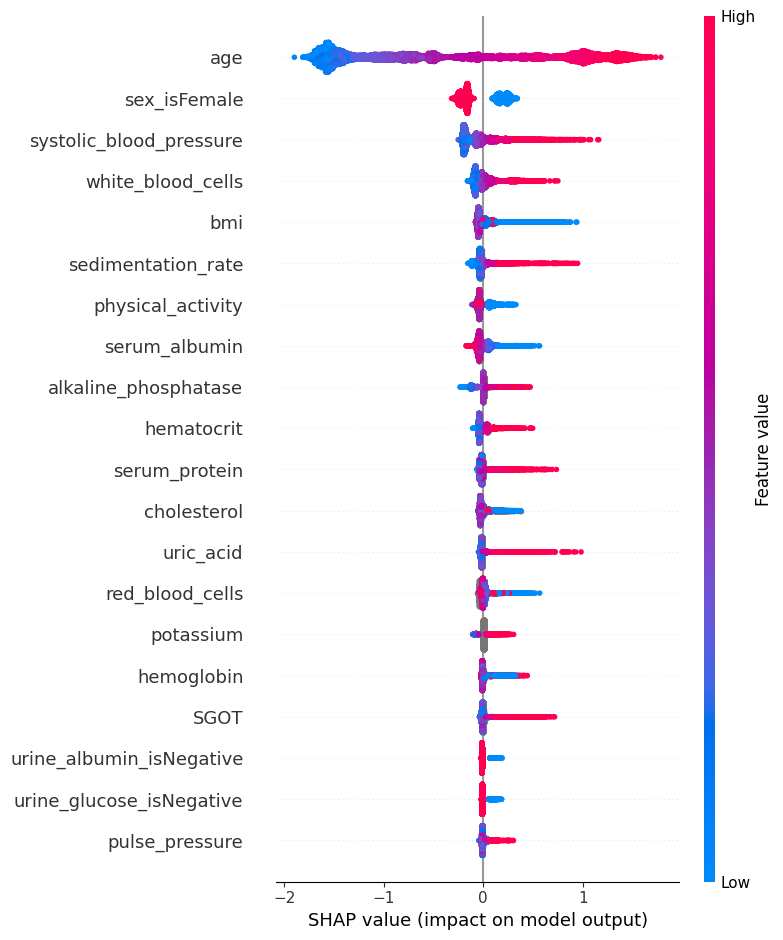

In [9]:
shap.summary_plot(shap_values, X)

### SHAP Dependence Plots

While a SHAP summary plot gives a general overview of each feature, a SHAP dependence plot shows how the model output varies by feature value. Note that every dot is a person, and the vertical dispersion at a single feature value results from interaction effects in the model. The feature used for coloring is automatically chosen to highlight what might be driving these interactions. Later we will see how to check that the interaction is really in the model with SHAP interaction values. Note that the row of a SHAP summary plot results from projecting the points of a SHAP dependence plot onto the y-axis, then recoloring by the feature itself.

Below we give the SHAP dependence plot for each of the NHANES I features, revealing interesting but expected trends. Keep in mind the calibration of some of these values can be different than a modern lab test so be careful drawing conclusions.

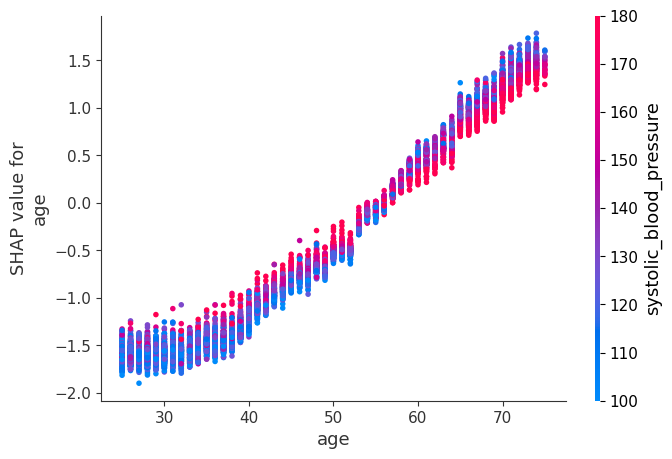

In [10]:
# we pass "age" instead of an index because dependence_plot() will find it in X's column names for us
# Systolic BP was automatically chosen for coloring based on a potential interaction to check that
# the interaction is really in the model see SHAP interaction values below
shap.dependence_plot("age", shap_values, X)

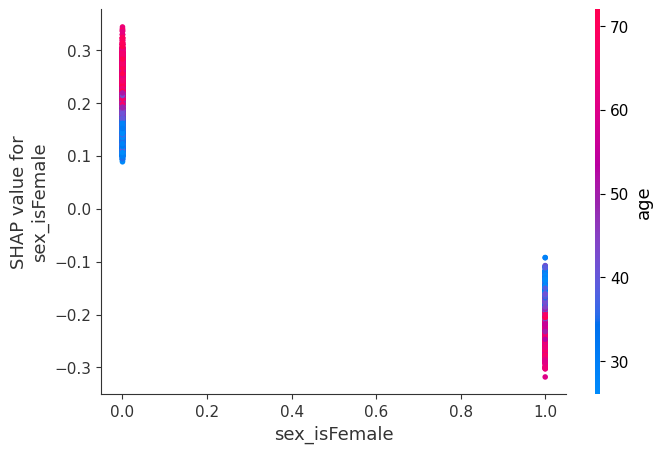

In [11]:
# we pass display_features so we get text display values for sex
shap.dependence_plot("sex_isFemale", shap_values, X, display_features=X_display)

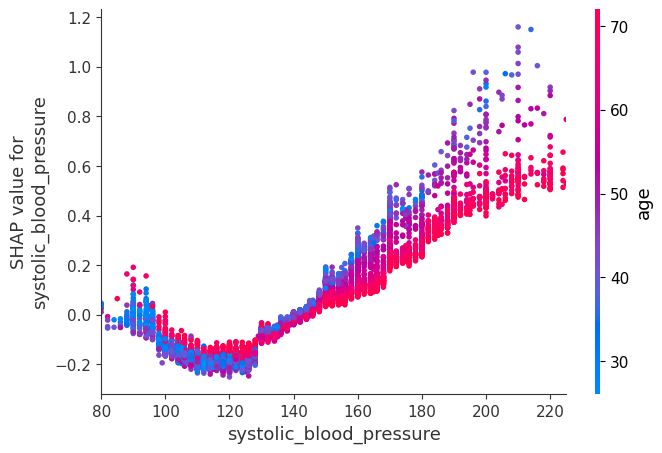

In [12]:
# setting show=False allows us to continue customizing the matplotlib plot before displaying it
shap.dependence_plot("systolic_blood_pressure", shap_values, X, show=False)
pl.xlim(80, 225)
pl.show()

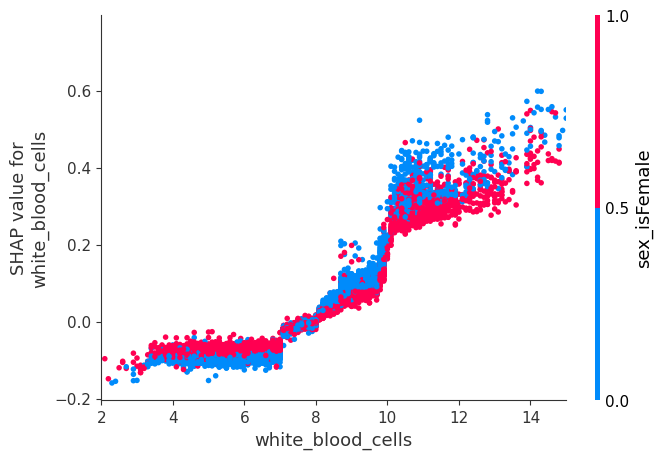

In [13]:
shap.dependence_plot("white_blood_cells", shap_values, X, display_features=X_display, show=False)
pl.xlim(2, 15)
pl.show()

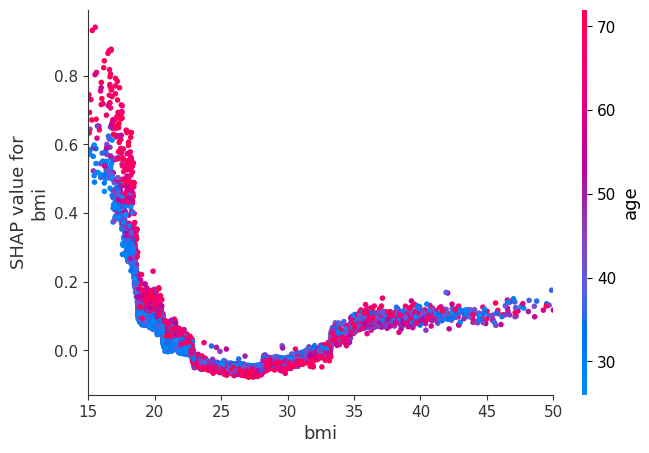

In [14]:
shap.dependence_plot("bmi", shap_values, X, display_features=X_display, show=False)
pl.xlim(15, 50)
pl.show()

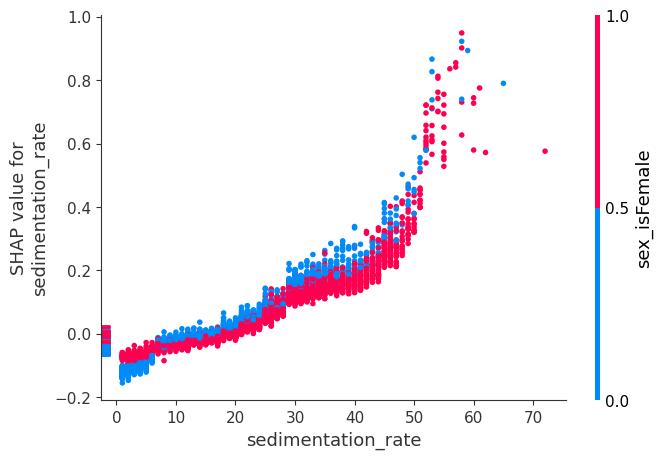

In [15]:
shap.dependence_plot("sedimentation_rate", shap_values, X)

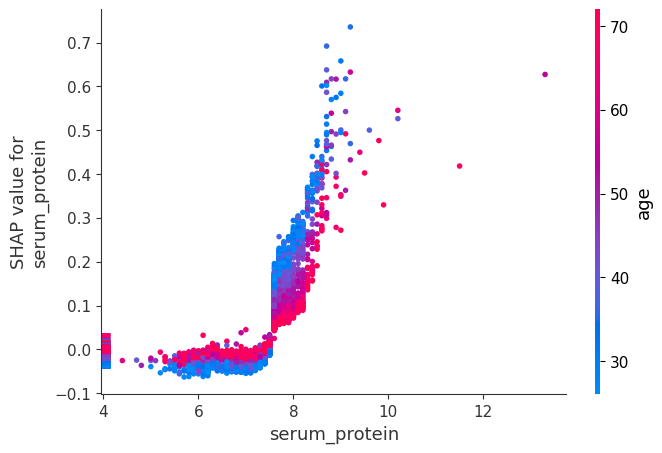

In [16]:
shap.dependence_plot("serum_protein", shap_values, X)

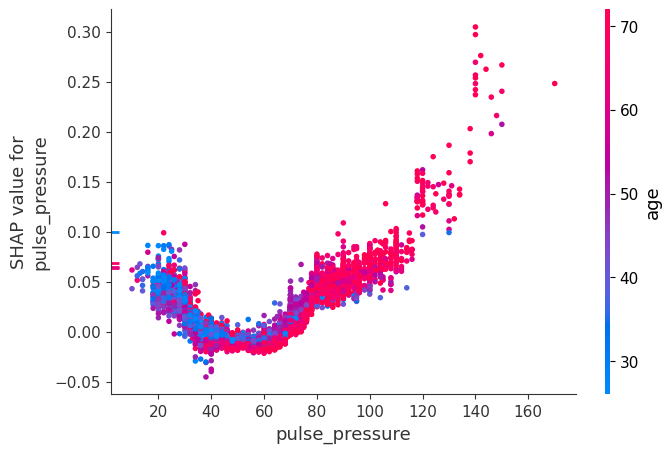

In [17]:
shap.dependence_plot("pulse_pressure", shap_values, X)

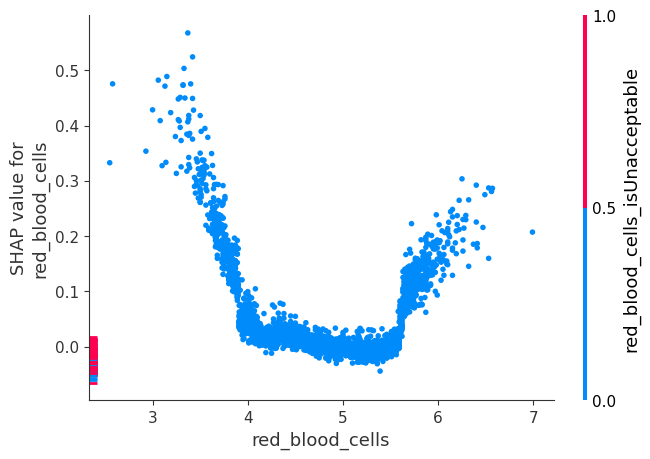

In [18]:
shap.dependence_plot("red_blood_cells", shap_values, X)

## Compute SHAP Interaction Values

See the Tree SHAP paper for more details, but briefly, SHAP interaction values are a generalization of SHAP values to higher order interactions. Fast exact computation of pairwise interactions are implemented in the later versions of XGBoost (>=1.0.0) with the pred_interactions flag. With this flag XGBoost returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. 

The main effects are similar to the SHAP values you would get for a linear model, and the interaction effects capture all the higher-order interactions and divide them up among the pairwise interaction terms. Note that the sum of the entire interaction matrix is the difference between the model's current output and expected output, and so the interaction effects on the off-diagonal are split in half (since there are two of each). 

When plotting interaction effects the SHAP package automatically multiplies the off-diagonal values by two to get the full interaction effect.

In [19]:
# we only take 300 people in order to run quicker
number_patients = 300

shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X.iloc[:number_patients, :])

### SHAP Interaction Value Summary Plot

A summary plot of a SHAP interaction value matrix plots a matrix of summary plots with the main effects on the diagonal and the interaction effects off the diagonal.

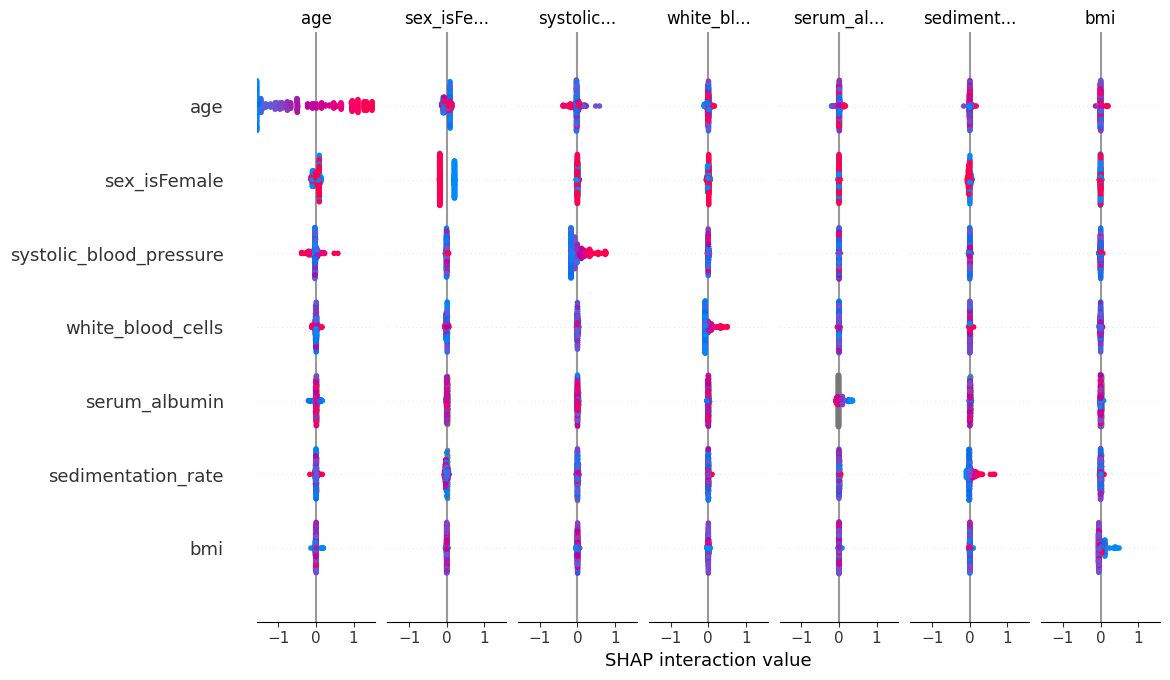

In [20]:
shap.summary_plot(shap_interaction_values, X.iloc[:number_patients, :])

### SHAP Interaction Value Dependence Plots

Running a dependence plot on the SHAP interaction values allows us to separately observe the main effects and the interaction effects.

Below we plot the main effects for age and some of the interaction effects for age. It is informative to compare the main effects plot of age with the earlier SHAP value plot for age. The main effects plot has no vertical dispersion because the interaction effects are all captured in the off-diagonal terms.

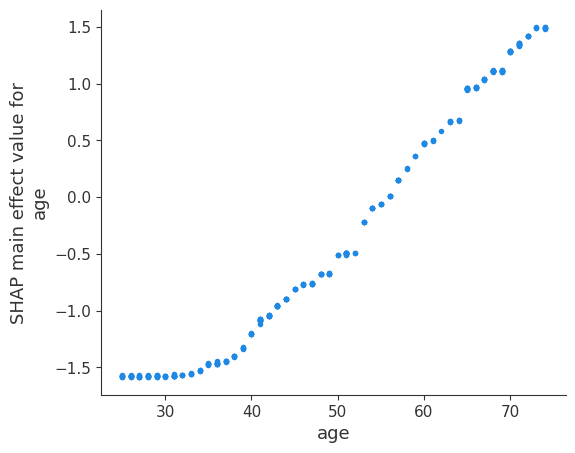

In [21]:
shap.dependence_plot(
    ("age", "age"),
    shap_interaction_values,
    X.iloc[:number_patients, :],
    display_features=X_display.iloc[:number_patients, :],
)

Now we plot the interaction effects involving age. These effects capture all of the vertical dispersion that was present in the original SHAP plot but is missing from the main effects plot above. The plot below involving age and sex shows that the sex-based death risk gap varies by age and peaks at age 60.

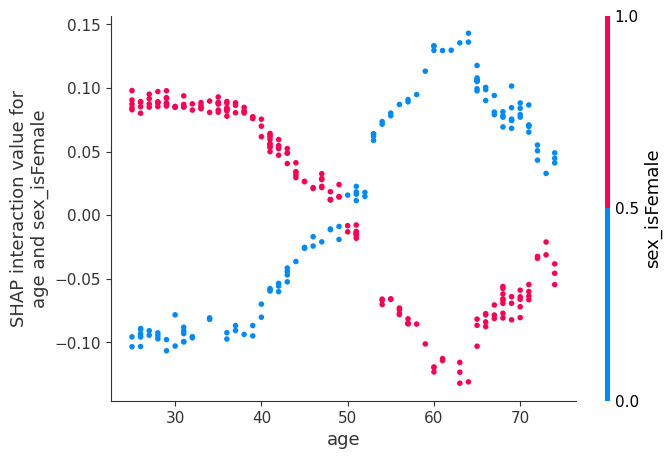

In [22]:
shap.dependence_plot(
    ("age", "sex_isFemale"),
    shap_interaction_values,
    X.iloc[:number_patients, :],
    display_features=X_display.iloc[:number_patients, :],
)

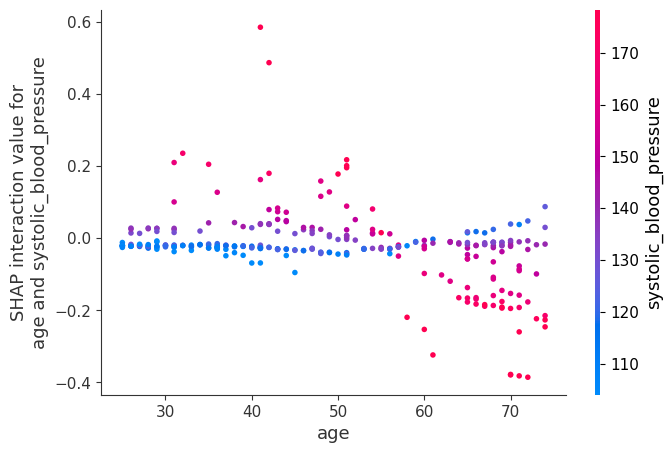

In [23]:
shap.dependence_plot(
    ("age", "systolic_blood_pressure"),
    shap_interaction_values,
    X.iloc[:number_patients, :],
    display_features=X_display.iloc[:number_patients, :],
)

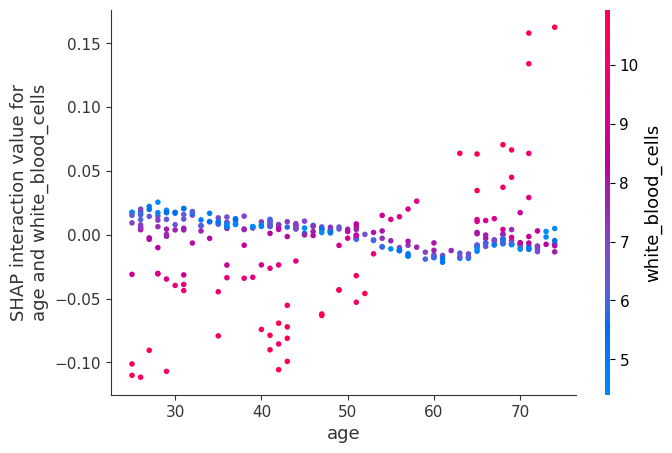

In [24]:
shap.dependence_plot(
    ("age", "white_blood_cells"),
    shap_interaction_values,
    X.iloc[:number_patients, :],
    display_features=X_display.iloc[:number_patients, :],
)

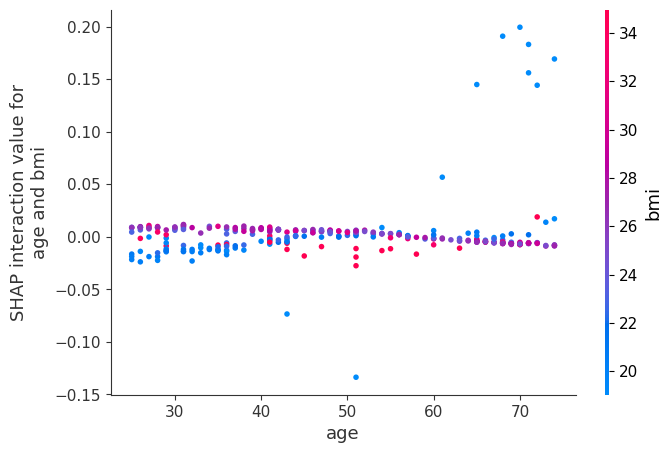

In [25]:
shap.dependence_plot(
    ("age", "bmi"),
    shap_interaction_values,
    X.iloc[:number_patients, :],
    display_features=X_display.iloc[:number_patients, :],
)

Now we show a couple examples with systolic blood pressure.

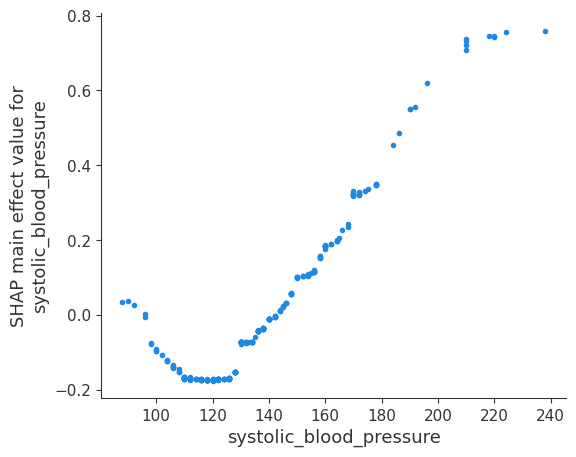

In [26]:
shap.dependence_plot(
    ("systolic_blood_pressure", "systolic_blood_pressure"),
    shap_interaction_values,
    X.iloc[:number_patients, :],
    display_features=X_display.iloc[:number_patients, :],
)

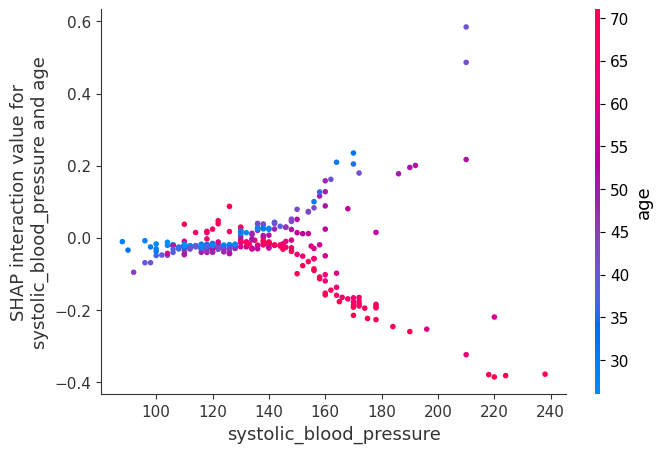

In [27]:
shap.dependence_plot(
    ("systolic_blood_pressure", "age"),
    shap_interaction_values,
    X.iloc[:number_patients, :],
    display_features=X_display.iloc[:number_patients, :],
)

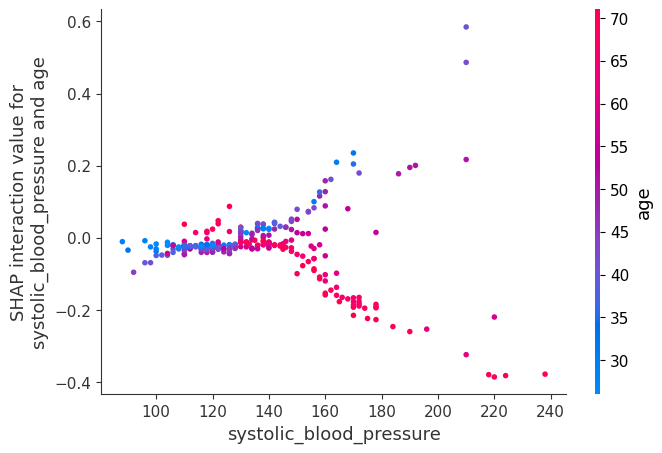

In [28]:
shap.dependence_plot(
    ("systolic_blood_pressure", "age"),
    shap_interaction_values,
    X.iloc[:number_patients, :],
    display_features=X_display.iloc[:number_patients, :],
)

We sum up the interaction over all patients to plot a which features interact the most. Note that we do not analyze how the features interact (high feature A + low feature B leads to outcome C, etc.).
Light colors show strong interaction effects

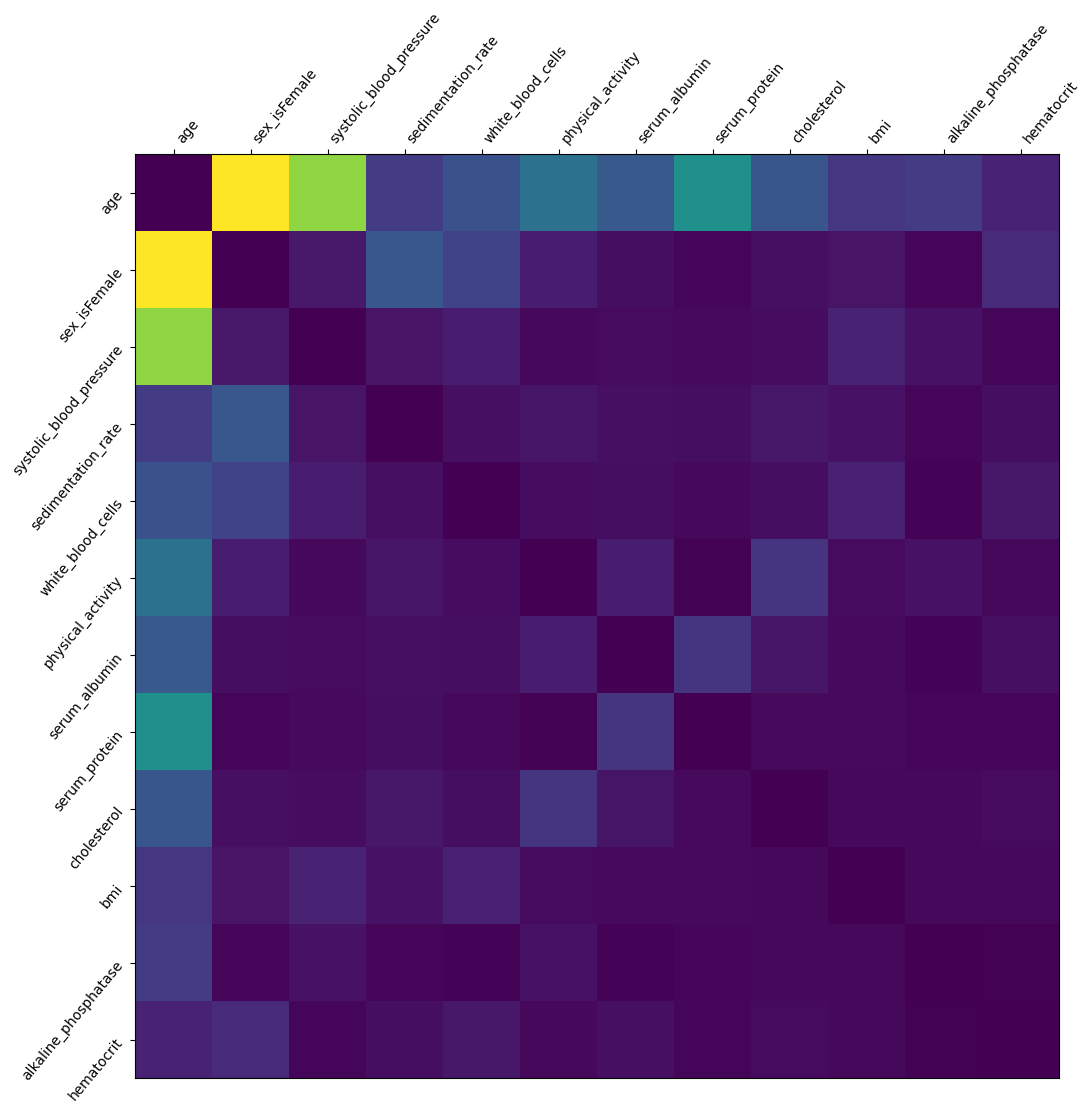

In [29]:
interaction_matrix = np.abs(shap_interaction_values).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:12]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
pl.figure(figsize=(12, 12))
pl.imshow(sorted_ia_matrix)
pl.yticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="right",
)
pl.xticks(
    range(sorted_ia_matrix.shape[0]),
    X.columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
pl.gca().xaxis.tick_top()
pl.show()